In [95]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

In [96]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        # if 'GMSC' in spname and 'ASHT' in spname[2]:
        #     for c in columns[:-2]:
        #         ret_string += str(spline[c]) + ','
        #     ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

In [97]:
def add_label_column_df(df):
    for index, row in df.iterrows():
        _str = row["algorithm"]

        if "RUNPER" in _str:
            df.at[index, 'label'] = "Parallel"
        else:
            df.at[index, 'label'] = "Sequential"
            
    return df

In [122]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    df = add_label_column_df(df)
    return select_columns_and_rename_values(df)

In [123]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [124]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

In [125]:
#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']

    labels = df.label

    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
  
    ax.plot(x, pd.to_numeric(df.acc), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg.replace("RUNPER", "").replace("Sequential", "")}')
    
    # ax.plot(x, pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
    # ax.plot(x, pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')

    #ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(60,100)

In [126]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey='row')
    filename = datetime.datetime.now()
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id)]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds], alg)
            if tables:
                display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%4 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
#             if int(my_id/2) == 1:
#                 ax.set_xlabel('Batch sizes')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)), bbox_to_anchor=(0.5,-0.10))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight', format='eps', dpi=1200)

In [127]:
from pandas.api.types import is_numeric_dtype

def mean_str(col):
    if is_numeric_dtype(col):
        return col.mean()
    else:
        return col.unique()[0] if col.nunique() == 1 else np.NaN

In [128]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/

#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/sem-coletor/dvfs/1200/1200/first"
wantedCSVfilename = "data-batch-vs-acc-1200-1200.csv"

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

dvf4 = load_df(f'{csvFile}')

# pega execução sequencial e bota em um novo dataframe
df_sequential = dvf4.loc[(dvf4.cores == 1) & (dvf4.batch_size == 1)]

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagASHTExecutorRUNPER,25,4,1,1,"45,312.00",33.65,83.36,83.12,82.67,0.00
1,covtypeNorm,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"62,730.00",521.48,93.08,87.61,87.40,0.00
2,GMSC,StreamingRandomPatches,25,1,1,1,"35,940.00",122.37,93.51,76.71,51.92,0.00
3,elecNormNew,LeveragingBag,25,1,1,1,"45,312.00",88.33,89.85,89.85,89.31,280.00
4,airlines,LeveragingBag,25,1,1,1,"5,780.00",126.64,64.34,57.77,55.27,12.00
5,covtypeNorm,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"152,860.00",380.52,91.49,82.46,79.54,0.00
6,elecNormNew,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"45,312.00",103.11,88.82,88.79,88.26,0.00
7,covtypeNorm,OzaBagAdwinExecutorRUNPER,25,4,1,1,"115,970.00",275.25,89.21,80.78,79.97,0.00
8,GMSC,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"150,000.00",214.08,93.52,76.94,54.40,0.00
9,elecNormNew,OzaBagASHT,25,1,1,1,"45,312.00",30.35,83.26,83.12,82.43,0.00


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

In [113]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/

#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/sem-coletor/dvfs/1200/1200/first"
wantedCSVfilename = "data-batch-vs-acc-1200-1200.csv"

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

dvf4 = load_df(f'{csvFile}')

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

In [132]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
#Folder inside results directory that contains all the MOA dump files for these experiments
# results para os experimentos cl4 (4 cores e t)

def prepare_dataframe(experiments, folderMOADumps, wantedCSVfilename):
    total_experiments = len(experiments)
    count = 0
    acc_sum = 0
    dvf4_list = []
    for experiment in experiments:
        resultsFolder = f"{folderMOADumps}/{experiment}"
        csvFile = f"parsed_csvs/{wantedCSVfilename}"
        directory = os.fsencode(resultsFolder)
        header_printed = False

        with open(f"{csvFile}", "w+") as output:
            for file in os.listdir(directory):
                filename = os.fsdecode(file)
                if filename.startswith("dump-"): 
                    output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

        dvf4_temp = load_df(f'{csvFile}')
        dvf4_temp = add_label_column_df(dvf4_temp)

        dvf4_list.append(dvf4_temp)


    #concat the dflist along axis 0 to put the data frames on top of each other
    df_concat=pd.concat(dvf4_list,axis=0)

    dvf4 = df_concat.groupby(level=0).agg(mean_str)
    return dvf4

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


In [134]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
#Folder inside results directory that contains all the MOA dump files for these experiments
# results para os experimentos cl4 (4 cores e t)

experiments = ["experiment-1", "experiment-2", "experiment-3", "experiment-4",
               "experiment-5", "experiment-6", "experiment-7", "experiment-8", "experiment-9", "experiment-10"]
folderMOADumps = "/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/sem-coletor/clf/4/1200/1200"
wantedCSVfilename = "data-batch-vs-acc-1200-1200-first.csv"

total_experiments = len(experiments)
count = 0
acc_sum = 0
dvf4_list = []
for experiment in experiments:
    resultsFolder = f"{folderMOADumps}/{experiment}"
    csvFile = f"parsed_csvs/{wantedCSVfilename}"
    directory = os.fsencode(resultsFolder)
    header_printed = False

    with open(f"{csvFile}", "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("dump-"): 
                output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

    dvf4_temp = load_df(f'{csvFile}')
    dvf4_temp = add_label_column_df(dvf4_temp)

    dvf4_list.append(dvf4_temp)


#concat the dflist along axis 0 to put the data frames on top of each other
df_concat=pd.concat(dvf4_list,axis=0)

# display(df_concat.sort_values(['dataset', 'algorithm']))

# # group by and calculating mean on index
dvf4 = df_concat.groupby(level=0).agg(mean_str)

display(dvf4)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagASHTExecutorRUNPER,25,4,1,1,"45,312.00",38.16,83.36,83.12,82.67,0.00
1,covtypeNorm,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"61,840.00",526.16,93.00,87.59,87.45,0.00
2,covtypeNorm,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"162,030.00",403.79,91.61,82.49,79.67,0.00
3,elecNormNew,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"45,312.00",113.80,88.82,88.79,88.26,0.00
4,covtypeNorm,OzaBagAdwinExecutorRUNPER,25,4,1,1,"139,120.00",303.79,89.04,80.72,79.53,0.00
5,GMSC,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"150,000.00",284.18,93.52,76.94,54.40,0.00
6,airlines,LBagExecutorRUNPER,25,4,1,1,"214,230.00","1,559.01",65.13,60.55,58.35,"1,224.00"
7,elecNormNew,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"45,312.00",192.14,89.69,89.68,89.15,0.00
8,covtypeNorm,OzaBagASHTExecutorRUNPER,25,4,1,1,"104,510.00",240.68,86.99,72.23,74.63,0.00
9,GMSC,OzaBagASHTExecutorRUNPER,25,4,1,1,"150,000.00",86.07,93.40,76.96,51.81,0.00


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagASHTExecutorRUNPER,25,4,1,1,"45,312.00",33.71,83.36,83.12,82.67,0.00
1,covtypeNorm,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"58,490.00",518.99,92.93,87.45,87.34,0.00
2,covtypeNorm,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"157,170.00",397.86,91.60,82.49,79.62,0.00
3,elecNormNew,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"45,312.00",96.43,88.82,88.79,88.26,0.00
4,covtypeNorm,OzaBagAdwinExecutorRUNPER,25,4,1,1,"104,230.00",287.00,88.63,80.65,80.22,0.00
5,GMSC,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"150,000.00",250.10,93.52,76.94,54.40,0.00
6,airlines,LBagExecutorRUNPER,25,4,1,1,"214,470.00","1,537.52",65.12,60.57,58.37,"1,226.00"
7,elecNormNew,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"45,312.00",180.28,89.54,89.56,88.97,0.00
8,covtypeNorm,OzaBagASHTExecutorRUNPER,25,4,1,1,"93,430.00",238.28,86.07,71.95,74.59,0.00
9,GMSC,OzaBagASHTExecutorRUNPER,25,4,1,1,"150,000.00",99.68,93.40,76.96,51.81,0.00


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagASHTExecutorRUNPER,25,4,1,1,"45,312.00",34.23,83.36,83.12,82.67,0.00
1,covtypeNorm,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"61,700.00",519.83,93.09,87.49,87.41,0.00
2,covtypeNorm,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"148,790.00",399.78,91.39,82.43,79.41,0.00
3,elecNormNew,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"45,312.00",95.74,88.82,88.79,88.26,0.00
4,covtypeNorm,OzaBagAdwinExecutorRUNPER,25,4,1,1,"109,120.00",301.85,88.83,80.69,80.13,0.00
5,GMSC,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"150,000.00",232.36,93.52,76.94,54.40,0.00
6,airlines,LBagExecutorRUNPER,25,4,1,1,"216,920.00","1,514.29",65.09,60.72,58.54,"1,245.00"
7,elecNormNew,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"45,312.00",183.64,89.33,89.36,88.75,0.00
8,covtypeNorm,OzaBagASHTExecutorRUNPER,25,4,1,1,"102,630.00",239.59,86.84,72.15,74.71,0.00
9,GMSC,OzaBagASHTExecutorRUNPER,25,4,1,1,"150,000.00",81.45,93.40,76.96,51.81,0.00


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagASHTExecutorRUNPER,25,4,1,1,"45,312.00",35.89,83.36,83.12,82.67,0.00
1,covtypeNorm,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"58,420.00",514.63,92.95,87.45,87.37,0.00
2,covtypeNorm,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"154,970.00",383.67,91.55,82.47,79.58,0.00
3,elecNormNew,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"45,312.00",100.52,88.82,88.79,88.26,0.00
4,covtypeNorm,OzaBagAdwinExecutorRUNPER,25,4,1,1,"132,800.00",299.29,88.77,80.56,79.51,0.00
5,GMSC,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"150,000.00",232.53,93.52,76.94,54.40,0.00
6,airlines,LBagExecutorRUNPER,25,4,1,1,"221,360.00","1,522.52",65.02,60.99,58.88,"1,286.00"
7,elecNormNew,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"45,312.00",175.39,89.64,89.63,89.10,0.00
8,covtypeNorm,OzaBagASHTExecutorRUNPER,25,4,1,1,"102,290.00",242.05,86.82,72.14,74.70,0.00
9,GMSC,OzaBagASHTExecutorRUNPER,25,4,1,1,"150,000.00",82.49,93.40,76.96,51.81,0.00


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagASHTExecutorRUNPER,25,4,1,1,"45,312.00",37.99,83.36,83.12,82.67,0.00
1,covtypeNorm,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"50,110.00",509.65,92.16,87.19,87.14,0.00
2,covtypeNorm,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"139,860.00",390.05,91.35,82.39,79.71,0.00
3,elecNormNew,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"45,312.00",102.26,88.82,88.79,88.26,0.00
4,covtypeNorm,OzaBagAdwinExecutorRUNPER,25,4,1,1,"109,750.00",297.28,88.87,80.71,80.10,0.00
5,GMSC,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"150,000.00",294.87,93.52,76.94,54.40,0.00
6,airlines,LBagExecutorRUNPER,25,4,1,1,"215,650.00","1,539.88",65.11,60.64,58.45,"1,229.00"
7,elecNormNew,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"45,312.00",192.06,89.54,89.56,88.97,0.00
8,covtypeNorm,OzaBagASHTExecutorRUNPER,25,4,1,1,"88,400.00",237.60,85.63,71.90,74.56,0.00
9,GMSC,OzaBagASHTExecutorRUNPER,25,4,1,1,"150,000.00",97.12,93.40,76.96,51.81,0.00


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagASHTExecutorRUNPER,25,4,1,1,"45,312.00",38.78,83.36,83.12,82.67,0.00
1,covtypeNorm,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"64,420.00",530.55,93.13,87.51,87.41,0.00
2,covtypeNorm,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"158,510.00",390.12,91.64,82.50,79.65,0.00
3,elecNormNew,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"45,312.00",118.07,88.82,88.79,88.26,0.00
4,covtypeNorm,OzaBagAdwinExecutorRUNPER,25,4,1,1,"137,650.00",301.66,89.00,80.70,79.54,0.00
5,GMSC,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"150,000.00",229.71,93.52,76.94,54.40,0.00
6,airlines,LBagExecutorRUNPER,25,4,1,1,"210,290.00","1,544.73",65.28,60.50,58.26,"1,220.00"
7,elecNormNew,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"45,312.00",210.07,89.54,89.56,88.97,0.00
8,covtypeNorm,OzaBagASHTExecutorRUNPER,25,4,1,1,"103,540.00",240.86,86.92,72.21,74.73,0.00
9,GMSC,OzaBagASHTExecutorRUNPER,25,4,1,1,"150,000.00",85.62,93.40,76.96,51.81,0.00


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagASHTExecutorRUNPER,25,4,1,1,"45,312.00",36.84,83.36,83.12,82.67,0.00
1,covtypeNorm,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"44,990.00",519.74,91.37,86.92,86.88,0.00
2,covtypeNorm,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"137,110.00",381.05,91.35,82.39,80.01,0.00
3,elecNormNew,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"45,312.00",96.50,88.82,88.79,88.26,0.00
4,covtypeNorm,OzaBagAdwinExecutorRUNPER,25,4,1,1,"88,530.00",301.74,87.77,80.55,80.23,0.00
5,GMSC,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"150,000.00",305.45,93.52,76.94,54.40,0.00
6,airlines,LBagExecutorRUNPER,25,4,1,1,"186,950.00","1,612.82",65.73,60.27,57.95,"1,031.00"
7,elecNormNew,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"45,312.00",187.00,89.42,89.42,88.87,0.00
8,covtypeNorm,OzaBagASHTExecutorRUNPER,25,4,1,1,"59,570.00",216.12,82.43,71.10,73.69,0.00
9,GMSC,OzaBagASHTExecutorRUNPER,25,4,1,1,"150,000.00",88.67,93.40,76.96,51.81,0.00


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagASHTExecutorRUNPER,25,4,1,1,"45,312.00",35.50,83.36,83.12,82.67,0.00
1,covtypeNorm,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"54,670.00",515.98,92.60,87.23,87.13,0.00
2,covtypeNorm,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"160,440.00",449.00,91.63,82.50,79.66,0.00
3,elecNormNew,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"45,312.00",97.28,88.82,88.79,88.26,0.00
4,covtypeNorm,OzaBagAdwinExecutorRUNPER,25,4,1,1,"118,200.00",299.86,89.15,80.75,79.89,0.00
5,GMSC,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"150,000.00",269.71,93.52,76.94,54.40,0.00
6,airlines,LBagExecutorRUNPER,25,4,1,1,"222,580.00","1,531.31",65.02,61.08,58.99,"1,291.00"
7,elecNormNew,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"45,312.00",192.13,89.54,89.56,88.97,0.00
8,covtypeNorm,OzaBagASHTExecutorRUNPER,25,4,1,1,"84,620.00",230.37,85.40,71.90,74.53,0.00
9,GMSC,OzaBagASHTExecutorRUNPER,25,4,1,1,"150,000.00",99.21,93.40,76.96,51.81,0.00


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagASHTExecutorRUNPER,25,4,1,1,"45,312.00",43.00,83.36,83.12,82.67,0.00
1,covtypeNorm,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"61,530.00",532.27,93.11,87.47,87.39,0.00
2,covtypeNorm,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"146,300.00",389.69,91.30,82.39,79.34,0.00
3,elecNormNew,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"45,312.00",125.75,88.82,88.79,88.26,0.00
4,covtypeNorm,OzaBagAdwinExecutorRUNPER,25,4,1,1,"133,830.00",302.96,88.83,80.58,79.52,0.00
5,GMSC,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"150,000.00",227.93,93.52,76.94,54.40,0.00
6,airlines,LBagExecutorRUNPER,25,4,1,1,"225,220.00","1,532.95",65.04,61.09,59.02,"1,326.00"
7,elecNormNew,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"45,312.00",215.08,89.48,89.47,88.94,0.00
8,covtypeNorm,OzaBagASHTExecutorRUNPER,25,4,1,1,"107,050.00",242.47,87.17,72.26,74.69,0.00
9,GMSC,OzaBagASHTExecutorRUNPER,25,4,1,1,"150,000.00",81.81,93.40,76.96,51.81,0.00


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagASHTExecutorRUNPER,25,4,1,1,"45,312.00",37.46,83.36,83.12,82.67,0.00
1,covtypeNorm,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"59,660.00",518.18,93.01,87.49,87.38,0.00
2,covtypeNorm,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"149,000.00",390.85,91.40,82.43,79.42,0.00
3,elecNormNew,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"45,312.00",100.92,88.82,88.79,88.26,0.00
4,covtypeNorm,OzaBagAdwinExecutorRUNPER,25,4,1,1,"125,730.00",304.75,88.72,80.58,79.57,0.00
5,GMSC,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"150,000.00",247.12,93.52,76.94,54.40,0.00
6,airlines,LBagExecutorRUNPER,25,4,1,1,"220,050.00","1,531.31",65.04,60.93,58.79,"1,274.00"
7,elecNormNew,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"45,312.00",196.06,89.33,89.36,88.75,0.00
8,covtypeNorm,OzaBagASHTExecutorRUNPER,25,4,1,1,"98,790.00",239.68,86.55,72.01,74.62,0.00
9,GMSC,OzaBagASHTExecutorRUNPER,25,4,1,1,"150,000.00",91.05,93.40,76.96,51.81,0.00


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change,label
0,elecNormNew,OBASHTRUNPER,25.00,4.00,1.00,1.00,"45,312.00",37.16,83.36,83.12,82.67,0.00,Parallel
1,covtypeNorm,SRPRUNPER,25.00,4.00,1.00,1.00,"57,583.00",520.60,92.73,87.38,87.29,0.00,Parallel
2,covtypeNorm,ARFRUNPER,25.00,4.00,1.00,1.00,"151,418.00",397.59,91.48,82.45,79.61,0.00,Parallel
3,elecNormNew,ARFRUNPER,25.00,4.00,1.00,1.00,"45,312.00",104.73,88.82,88.79,88.26,0.00,Parallel
4,covtypeNorm,OBAdwinRUNPER,25.00,4.00,1.00,1.00,"119,896.00",300.02,88.76,80.65,79.82,0.00,Parallel
5,GMSC,ARFRUNPER,25.00,4.00,1.00,1.00,"150,000.00",257.40,93.52,76.94,54.40,0.00,Parallel
6,airlines,LBagRUNPER,25.00,4.00,1.00,1.00,"214,772.00","1,542.63",65.16,60.73,58.56,"1,235.20",Parallel
7,elecNormNew,SRPRUNPER,25.00,4.00,1.00,1.00,"45,312.00",192.39,89.51,89.51,88.94,0.00,Parallel
8,covtypeNorm,OBASHTRUNPER,25.00,4.00,1.00,1.00,"94,483.00",236.77,86.08,71.99,74.54,0.00,Parallel
9,GMSC,OBASHTRUNPER,25.00,4.00,1.00,1.00,"150,000.00",89.32,93.40,76.96,51.81,0.00,Parallel


In [135]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/

#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/sem-coletor/dvfs/600/600/first"
wantedCSVfilename = "data-batch-vs-acc-600-600.csv"

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

dvh4 = load_df(f'{csvFile}')

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagASHTExecutorRUNPER,25,4,1,1,"45,312.00",63.13,83.36,83.12,82.67,0.00
1,covtypeNorm,StreamingRandomPatchesExecutorRUNPER,25,4,1,1,"30,010.00",509.26,88.41,85.79,85.65,0.00
2,GMSC,StreamingRandomPatches,25,1,1,1,"17,780.00",122.10,93.62,74.64,51.24,0.00
3,elecNormNew,LeveragingBag,25,1,1,1,"31,260.00",121.42,89.86,89.93,89.22,186.00
4,airlines,LeveragingBag,25,1,1,1,"3,610.00",124.74,68.42,56.63,54.34,12.00
5,covtypeNorm,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"72,950.00",369.47,90.04,82.27,81.59,0.00
6,elecNormNew,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"45,312.00",173.90,88.82,88.79,88.26,0.00
7,covtypeNorm,OzaBagAdwinExecutorRUNPER,25,4,1,1,"54,990.00",271.00,86.78,80.42,80.25,0.00
8,GMSC,AdaptiveRandomForestExecutorRUNPER,25,4,1,1,"150,000.00",383.78,93.52,76.94,54.40,0.00
9,elecNormNew,OzaBagASHT,25,1,1,1,"45,312.00",57.56,83.26,83.12,82.43,0.00


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

In [82]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/

#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/sem-coletor/dvfs/dpm/2/600"
wantedCSVfilename = "data-batch-vs-acc-600-600-2.csv"

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

dvh2 = load_df(f'{csvFile}')
display(dvh2)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change,label
0,covtypeNorm,OBAdwinRUNPER,25,2,1,1,"59,740.00",344.72,87.21,80.66,80.34,0.00,Parallel
1,GMSC,ARFRUNPER,25,2,1,1,"135,990.00",413.47,93.55,76.65,54.29,0.00,Parallel
2,airlines,LBagRUNPER,25,2,1,1,"134,060.00","2,323.56",65.80,59.94,57.65,747.00,Parallel
3,elecNormNew,SRPRUNPER,25,2,1,1,"45,312.00",409.81,89.76,89.78,89.20,0.00,Parallel
4,covtypeNorm,OBASHTRUNPER,25,2,1,1,"37,580.00",235.19,75.73,68.55,71.45,0.00,Parallel
5,elecNormNew,OBASHTRUNPER,25,2,1,1,"45,312.00",70.94,83.36,83.12,82.67,0.00,Parallel
6,covtypeNorm,SRPRUNPER,25,2,1,1,"29,640.00",578.15,88.36,85.72,85.76,0.00,Parallel
7,covtypeNorm,ARFRUNPER,25,2,1,1,"77,040.00",433.24,90.10,82.28,81.51,0.00,Parallel
8,elecNormNew,ARFRUNPER,25,2,1,1,"45,312.00",216.68,88.82,88.79,88.26,0.00,Parallel
9,GMSC,OBASHTRUNPER,25,2,1,1,"150,000.00",166.18,93.40,76.96,51.81,0.00,Parallel


In [83]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
#Folder inside results directory that contains all the MOA dump files for these experiments
# resultados para cl2 (apenas 2 cores e rodando na frequencia maxima 1200x1200)
experiments = ["experiment-1", "experiment-2", "experiment-3", "experiment-4",
               "experiment-5", "experiment-6", "experiment-7", "experiment-8", "experiment-9", "experiment-10"]
folderMOADumps = "/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/sem-coletor/clf/2/1200/1200"
wantedCSVfilename = "data-batch-vs-acc-2-600-600-first.csv"

total_experiments = len(experiments)
count = 0
acc_sum = 0
dvf2_list = []
for experiment in experiments:
    resultsFolder = f"{folderMOADumps}/{experiment}"
    csvFile = f"parsed_csvs/{wantedCSVfilename}"
    directory = os.fsencode(resultsFolder)
    header_printed = False

    with open(f"{csvFile}", "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("dump-"): 
                output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

    dvf2_temp = load_df(f'{csvFile}')
    dvf2_temp = add_label_column_df(dvf2_temp)

    dvf2_list.append(dvf2_temp)


#concat the dflist along axis 0 to put the data frames on top of each other
df_concat=pd.concat(dvf2_list,axis=0)

# display(df_concat.sort_values(['dataset', 'algorithm']))

# # group by and calculating mean on index
dvf2 = df_concat.groupby(level=0).agg(mean_str)

display(dvf2)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change,label
0,covtypeNorm,OBAdwinRUNPER,25.00,2.00,1.00,1.00,"118,316.00",333.25,89.13,80.74,79.87,0.00,Parallel
1,GMSC,ARFRUNPER,25.00,2.00,1.00,1.00,"150,000.00",250.49,93.52,76.94,54.40,0.00,Parallel
2,airlines,LBagRUNPER,25.00,2.00,1.00,1.00,"204,786.00","1,858.52",65.42,60.44,58.16,"1,178.30",Parallel
3,elecNormNew,SRPRUNPER,25.00,2.00,1.00,1.00,"45,312.00",219.41,89.76,89.78,89.20,0.00,Parallel
4,covtypeNorm,OBASHTRUNPER,25.00,2.00,1.00,1.00,"105,074.00",274.39,87.03,72.23,74.67,0.00,Parallel
5,elecNormNew,OBASHTRUNPER,25.00,2.00,1.00,1.00,"45,312.00",38.99,83.36,83.12,82.67,0.00,Parallel
6,covtypeNorm,SRPRUNPER,25.00,2.00,1.00,1.00,"62,237.00",587.52,93.10,87.45,87.37,0.00,Parallel
7,covtypeNorm,ARFRUNPER,25.00,2.00,1.00,1.00,"144,360.00",416.31,91.33,82.40,79.59,0.00,Parallel
8,elecNormNew,ARFRUNPER,25.00,2.00,1.00,1.00,"45,312.00",116.78,88.82,88.79,88.26,0.00,Parallel
9,GMSC,OBASHTRUNPER,25.00,2.00,1.00,1.00,"150,000.00",90.04,93.40,76.96,51.81,0.00,Parallel


In [84]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/

#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/sem-coletor/mini-batching-medium/600/1200/first"
wantedCSVfilename = "data-batch-vs-acc-600-1200.csv"

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df_mb = load_df(f'{csvFile}')

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

In [85]:
def add_label_column_df(df):
    for index, row in df.iterrows():
        _str = row["algorithm"]

        if "RUNPER" in _str and row["batch_size"] == 1:
            df.at[index, 'label'] = "Parallel"
        elif row["batch_size"] == 1:
            df.at[index, 'label'] = "Seq"
        else:
            df.at[index, 'label'] = row["batch_size"]
            
    return df

In [86]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
#Folder inside results directory that contains all the MOA dump files for these experiments

experiments = ["experiment-1", "experiment-2", "experiment-3", "experiment-4",
               "experiment-5", "experiment-6", "experiment-7", "experiment-8", "experiment-9", "experiment-10"]
folderMOADumps = "/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/loop-fusion/acc-redudance"
wantedCSVfilename = "data-batch-vs-acc-600-1200-first.csv"

total_experiments = len(experiments)
count = 0
acc_sum = 0
dfmblf = []
for experiment in experiments:
    resultsFolder = f"{folderMOADumps}/{experiment}"
    csvFile = f"parsed_csvs/{wantedCSVfilename}"
    directory = os.fsencode(resultsFolder)
    header_printed = False

    with open(f"{csvFile}", "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("dump-"): 
                output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

    dfmblf_temp = load_df(f'{csvFile}')
    dfmblf_temp = add_label_column_df(dfmblf_temp)
    dfmblf_temp = dfmblf_temp.loc[dfmblf_temp.batch_size == 50]
    dfmblf_temp['batch_size'] = 'MB-LF'

    dfmblf.append(dfmblf_temp)


#concat the dflist along axis 0 to put the data frames on top of each other
df_concat=pd.concat(dfmblf,axis=0)

# display(df_concat.sort_values(['dataset', 'algorithm']))

# # group by and calculating mean on index
dfmblf = df_concat.groupby(level=0).agg(mean_str)

display(dfmblf)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24821/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequent

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change,label
0,elecNormNew,OBMB,25.00,4.00,MB-LF,1.00,"45,312.00",11.19,77.52,78.56,75.42,0.00,50.00
1,airlines,OBMB,25.00,4.00,MB-LF,1.00,"539,383.00",122.32,60.94,60.97,58.57,0.00,50.00
2,GMSC,SRPMB,25.00,4.00,MB-LF,1.00,"150,000.00",181.70,93.51,79.54,52.90,0.00,50.00
3,GMSC,ARFMB,25.00,4.00,MB-LF,1.00,"150,000.00",108.61,93.53,76.95,54.53,0.00,50.00
4,elecNormNew,OBASHTMB,25.00,4.00,MB-LF,1.00,"45,312.00",11.75,76.86,78.45,74.47,0.00,50.00
5,GMSC,OBMB,25.00,4.00,MB-LF,1.00,"150,000.00",23.03,93.35,73.93,53.54,0.00,50.00
6,elecNormNew,OBAdwinMB,25.00,4.00,MB-LF,1.00,"45,312.00",19.73,84.26,84.53,83.13,0.00,50.00
7,airlines,ARFMB,25.00,4.00,MB-LF,1.00,"539,383.00","2,839.69",66.13,65.71,65.03,0.00,50.00
8,airlines,SRPMB,25.00,4.00,MB-LF,1.00,"539,383.00","2,642.71",67.90,67.69,66.68,0.00,50.00
9,airlines,LBagMB,25.00,4.00,MB-LF,1.00,"539,383.00","3,140.97",64.03,63.57,62.64,"10,747.00",50.00


In [87]:
def build_label(df):
    for index, row in df.iterrows():
        if ((row['algorithm'].find('Sequential') > 0 or row['batch_size'] == 1) and row['cores'] == 1):
            df.at[index, 'label'] = "S"
            
        if (row['cores'] == 4 and row['batch_size'] == 50):
            df.at[index, 'label'] = "MB"
            
        if (row['cores'] == 4 and row['batch_size'] == "MB-LF"):
            df.at[index, 'label'] = "MB-LF"

        if (row['algorithm'].find('RUNPER') > 0 and row['cores'] == 2 and row['frequency_maximum'] == "600"):
            df.at[index, 'label'] = "FH2"
            
        if (row['algorithm'].find('RUNPER') > 0 and row['cores'] == 4 and row['frequency_maximum'] == "600"):
            df.at[index, 'label'] = "FH4"

        if (row['algorithm'].find('RUNPER') > 0 and row['cores'] == 2 and row['frequency_maximum'] == "1200"):
            df.at[index, 'label'] = "CL2"

        if (row['algorithm'].find('RUNPER') > 0 and row['cores'] == 4 and row['frequency_maximum'] == "1200"):
            df.at[index, 'label'] = "CL4"

    return df

In [88]:
dvh2 = dvh2.drop(dvh2[(dvh2.cores == 1) & (dvh2.batch_size == 1)].index) # rodado
dvh2['frequency_maximum'] = "600"
dvh4 = dvh4.drop(dvh4[(dvh4.cores == 1) & (dvh4.batch_size == 1)].index) # rodado
dvh4['frequency_maximum'] = "600"

dvf2 = dvf2.drop(dvf2[(dvf2.cores == 1) & (dvf2.batch_size == 1)].index) # rodado
dvf2['frequency_maximum'] = "1200"
dvf4 = dvf4.drop(dvf4[(dvf4.cores == 1) & (dvf4.batch_size == 1)].index) # rodado
dvf4['frequency_maximum'] = "1200"

# remove mb nao utilizados
df_mb = df_mb.drop(df_mb[df_mb.batch_size == 1].index)
df_mb = df_mb.drop(df_mb[df_mb.batch_size == 25].index)
df_mb = df_mb.drop(df_mb[df_mb.batch_size == 75].index)
df_mb = df_mb.drop(df_mb[df_mb.batch_size == 100].index)

df = pd.concat([df_sequential, dvh2, dvh4, dvf2, dvf4, df_mb, dfmblf])
df = build_label(df.reset_index())

df_mapping = pd.DataFrame({
    'label': ['S', 'FH2', 'FH4', 'CL2', 'CL4', 'MB', 'MB-LF'],
})
sort_mapping = df_mapping.reset_index().set_index('label')
df['label_num'] = df['label'].map(sort_mapping['index'])

df = df.drop_duplicates().sort_values('label_num')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


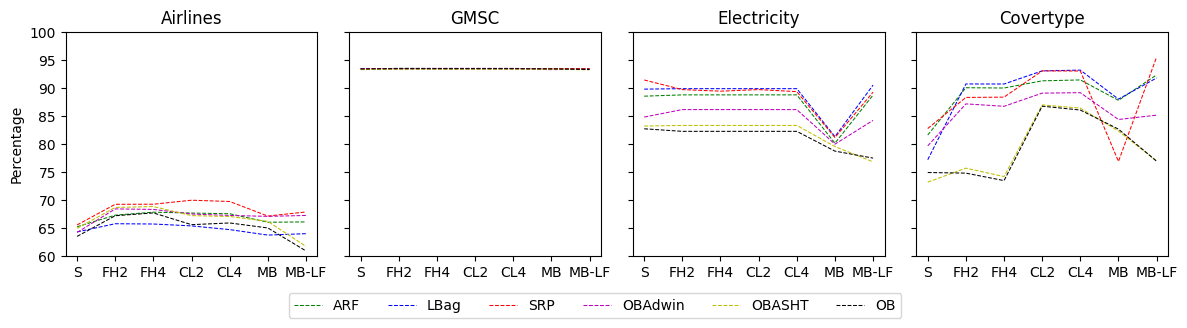

In [89]:
#false makes the chart without markers
gen_chart(df, False, False)

In [70]:
# pega execução sequencial e bota em um novo dataframe
df_sequential = dvf4.loc[(dvf4.cores == 1) & (dvf4.batch_size == 1)]

dvh2 = dvh2.drop(dvh2[(dvh2.cores == 1) & (dvh2.batch_size == 1)].index) # rodado
dvh2['frequency_maximum'] = "600"
dvh4 = dvh4.drop(dvh4[(dvh4.cores == 1) & (dvh4.batch_size == 1)].index) # rodado
dvh4['frequency_maximum'] = "600"

dvf2 = dvf2.drop(dvf2[(dvf2.cores == 1) & (dvf2.batch_size == 1)].index) # a rodar
dvf2['frequency_maximum'] = "1200"
dvf4 = dvf4.drop(dvf4[(dvf4.cores == 1) & (dvf4.batch_size == 1)].index) # rodado
dvf4['frequency_maximum'] = "1200"

# remove mb nao utilizados
df_mb = df_mb.drop(df_mb[df_mb.batch_size == 1].index)
df_mb = df_mb.drop(df_mb[df_mb.batch_size == 25].index)
df_mb = df_mb.drop(df_mb[df_mb.batch_size == 75].index)
df_mb = df_mb.drop(df_mb[df_mb.batch_size == 100].index)

df = pd.concat([df_sequential, dvh2, dvh4, dvf2, dvf4, df_mb])
df = build_label(df.reset_index())

df_mapping = pd.DataFrame({
    'label': ['S', 'FH2', 'FH4', 'CL2', 'CL4', 'MB'],
})
sort_mapping = df_mapping.reset_index().set_index('label')
df['label_num'] = df['label'].map(sort_mapping['index'])

df = df.drop_duplicates().sort_values('label_num')



In [103]:
#false makes the chart without markers
# gen_chart(df, False)